In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import matplotlib.pyplot as plt

!pip install gradio
import gradio as gr

from skimage import metrics
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
import cv2
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.2 MB/s eta 0:00:00


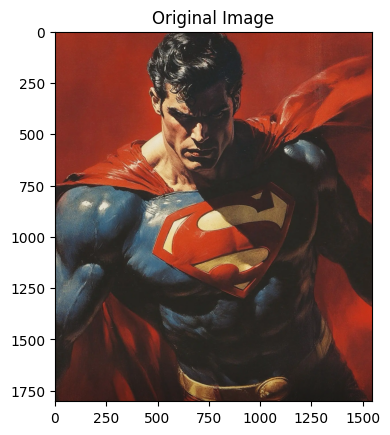

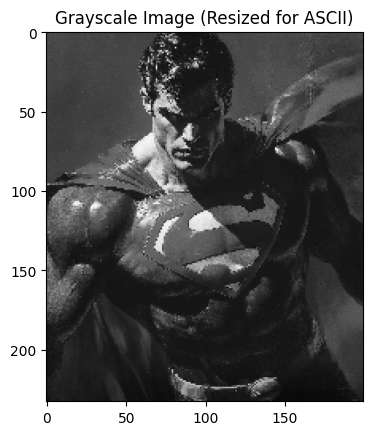

In [7]:
# Step 1: Load, Resize, and Convert to Grayscale
def load_and_prepare_image(image_path, new_width=500):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to load.")

    # Resize image for smaller ASCII output
    height, width, _ = image.shape
    aspect_ratio = height / width
    new_height = int(aspect_ratio * new_width * 1)  # Adjust for ASCII font aspect ratio
    resized_image = cv2.resize(image, (new_width, new_height))

    # Display the original image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for correct color display
    plt.title('Original Image')
    plt.show()

    # Convert to grayscale (using 0.299*R + 0.587*G + 0.114*B)
    grayscale = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    return grayscale

# Adjust the new_width parameter to a lower value to reduce ASCII art size
image_path = '/content/drive/MyDrive/CS5330/Lab1/apple.jpg'
grayscale_image = load_and_prepare_image(image_path, new_width=200)

plt.imshow(grayscale_image, cmap='gray')
plt.title('Grayscale Image (Resized for ASCII)')
plt.show()


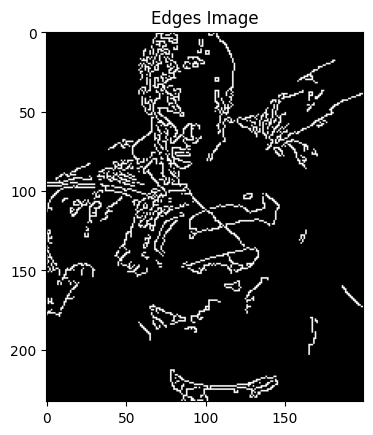

In [8]:
# Step 2: Apply Edge Detection (Canny)

def apply_edge_detection(grayscale_image, threshold1=100, threshold2=200):
    edges = cv2.Canny(grayscale_image, threshold1, threshold2)
    return edges

# Test Step 2
edges_image = apply_edge_detection(grayscale_image, threshold1=100, threshold2=200)
plt.imshow(edges_image, cmap='gray')
plt.title('Edges Image')
plt.show()

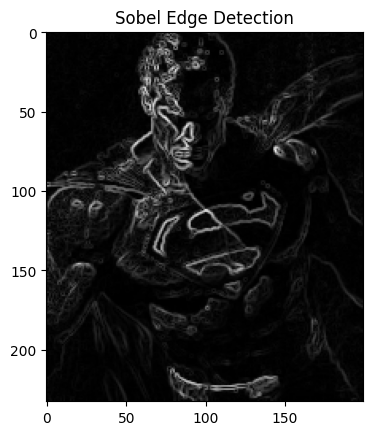

In [9]:
# Alternative for step 2: Sobel

# Sobel Edge Detection (X, Y, and combined)
def apply_sobel_edge_detection(grayscale_image):
    # Sobel X
    sobelx = cv2.Sobel(grayscale_image, cv2.CV_64F, 1, 0, ksize=3)
    # Sobel Y
    sobely = cv2.Sobel(grayscale_image, cv2.CV_64F, 0, 1, ksize=3)
    # Combined Sobel (Magnitude of X and Y)
    sobel_combined = np.sqrt(sobelx**2 + sobely**2)

    # Convert back to uint8
    sobel_combined = np.uint8(sobel_combined / np.max(sobel_combined) * 255)

    return sobel_combined

# Test Sobel Edge Detection
sobel_edges = apply_sobel_edge_detection(grayscale_image)
plt.imshow(sobel_edges, cmap='gray')
plt.title('Sobel Edge Detection')
plt.show()


In [10]:
# Step 3: ASCII Character Mapping
# ASCII_CHARS = ['@', '%', '#', '*', '+', '=', '-', ':', '.', ' ']
ASCII_CHARS = ['@', '#', '%', 'M', 'W', '8', '&', '$', 'B', 'O', 'o', 'Q', 'h', 'm', 'a', 'k', 'd', 'C', 'x', 'n', 'u', 'v', 'c', 't', 'l', '1', 'r', '/', '|', '(', ')', '{', '}', '[', ']', '?', '-', '_', '+', '~', '<', '>', '!', ';', ':', ',', '^', '"', '.', "'", ' ']


def map_pixels_to_ascii(image, ascii_chars=ASCII_CHARS):
    # Calculate the dimensions of the ASCII art
    height, width = image.shape
    ascii_width = width
    ascii_height = int(height / 2)  # Adjust for ASCII font aspect ratio

    # Resize the image to match the ASCII dimensions
    resized_image = cv2.resize(image, (ascii_width, ascii_height))

    ascii_image = []
    for row in resized_image:
        ascii_row = [ascii_chars[min(pixel // 25, len(ascii_chars) - 1)] for pixel in row]  # Scale pixel value (0-255) to index in ASCII_CHARS, prevent out-of-range
        ascii_image.append("".join(ascii_row))
    return "\n".join(ascii_image)

# Test Step 3
# ascii_art = map_pixels_to_ascii(edges_image)
ascii_art = map_pixels_to_ascii(sobel_edges)
print(ascii_art)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@##%@@###%M%@@@@@@@@@@@@@@@@@@@##@@#@#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@#@##@%%%M%%#%M#@@@@@@@@@@@@@@@@@@#@@@@##@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@##@@@##%%MM%%%MW#@@@@@@@@@@@@#@#@@@@@@@@@##@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@#@@#%%%M##MW8WW8M@@@@@@@@@@@@#@#@@@@@@@@@@####@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@#@@##8%%MM@@@#W8M@@###@@@@@@@@###@@@@@@@@@@@@@#%@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

## Step 4 Gradio UI (http://127.0.0.1:7860 & Public linked provided)

In [11]:

# Complete Function for Gradio Interface
def generate_ascii_art(image, new_width=100, threshold1=100, threshold2=200):
    # Step 1: Resize and Convert to Grayscale
    grayscale_image = load_and_prepare_image(image, new_width=new_width)

    # Step 2: Apply Edge Detection
    edges_image = apply_edge_detection(grayscale_image, threshold1=threshold1, threshold2=threshold2)

    # Step 3: Map to ASCII
    ascii_art = map_pixels_to_ascii(edges_image)

    # Step 4: Save ASCII art to a text file
    output_file_path = "ascii_art_output.txt"
    with open(output_file_path, "w") as file:
        file.write(ascii_art)

    return ascii_art, output_file_path

# Step 4: Gradio Interface
interface = gr.Interface(
    fn=generate_ascii_art,
    inputs=[
        gr.components.Image(type="filepath"), # Changed gr.inputs to gr.components
        gr.components.Slider(10, 200, value=100, label="Width"), # Changed gr.inputs to gr.components
        gr.components.Slider(50, 150, value=100, label="Edge Detection Threshold 1"), # Changed gr.inputs to gr.components
        gr.components.Slider(100, 250, value=200, label="Edge Detection Threshold 2") # Changed gr.inputs to gr.components
    ],
    outputs=[
        "text",  # ASCII art output as plain text
        gr.components.File(label="Download ASCII Art")  # Output for downloading the ASCII art file
    ],
    title="ASCII Art Generator",
    description="Upload an image, generate ASCII art, and download the result as a text file."
)

interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://501bb1e1ae57a5f113.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
# Step 5: Performance metric based on the suggested material


# Step 1: Sharpness (Edge Detection) - Compare Canny or Sobel edges
def calculate_sharpness(original, ascii_image):
    edges_original = cv2.Canny(original, 100, 200)
    edges_ascii = cv2.Canny(ascii_image, 100, 200)

    # Compute Structural Similarity Index (SSIM) between the edges
    sharpness_score, _ = ssim(edges_original, edges_ascii, full=True)
    return sharpness_score

# Step 2: Noise Reduction - Calculate Noise Variance
def calculate_noise(image):
    # Apply noise reduction to the image and compare noise variance
    noise = random_noise(image, mode='gaussian')
    noise_variance = np.var(noise - image)
    return noise_variance

def compare_noise(original, edge_detected_image):
    noise_original = calculate_noise(original)
    noise_ascii = calculate_noise(edge_detected_image)
    return abs(noise_original - noise_ascii)

# Step 3: Dynamic Range & Contrast - Histogram Comparison
def calculate_histogram(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    return cv2.normalize(hist, hist).flatten()

def compare_histograms(original, edge_detected_image):
    hist_original = calculate_histogram(original)
    hist_edges = calculate_histogram(edge_detected_image)

    # Compare histograms using correlation method
    histogram_score = cv2.compareHist(hist_original, hist_edges, cv2.HISTCMP_CORREL)
    return histogram_score

# Step 4: Artifacts (Pixel-to-Character Mapping Error)
def calculate_artifacts(original, edge_detected_image):
    # Calculate the pixel-to-character mapping error using MSE
    mse = metrics.mean_squared_error(original, edge_detected_image)
    return mse

# Performance evaluation for edge detection methods
def evaluate_edge_detection_performance(original_image, edge_detected_image):
    # Resize images to the same size for comparison if necessary
    original_image_resized = cv2.resize(original_image, (edge_detected_image.shape[1], edge_detected_image.shape[0]))

    sharpness_score = calculate_sharpness(original_image_resized, edge_detected_image)
    noise_diff = compare_noise(original_image_resized, edge_detected_image)
    histogram_score = compare_histograms(original_image_resized, edge_detected_image)
    artifact_score = calculate_artifacts(original_image_resized, edge_detected_image)

    return {
        'Sharpness (Edge Detection)': sharpness_score,
        'Noise Difference': noise_diff,
        'Dynamic Range & Contrast': histogram_score,
        'Artifacts (Pixel-to-Character Mapping Error)': artifact_score
    }

# Canny Edge Detection
def apply_canny_edge_detection(grayscale_image, threshold1=100, threshold2=200):
    return cv2.Canny(grayscale_image, threshold1, threshold2)

# Sobel Edge Detection (X, Y, and combined)
def apply_sobel_edge_detection(grayscale_image):
    sobelx = cv2.Sobel(grayscale_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(grayscale_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobelx**2 + sobely**2)
    sobel_combined = np.uint8(sobel_combined / np.max(sobel_combined) * 255)
    return sobel_combined

# Step 5: Test with sample images
# Load the original grayscale image
original_image = grayscale_image  # Assume grayscale_image is preloaded

# Apply Canny and Sobel edge detection
canny_edges_image = apply_canny_edge_detection(grayscale_image)
sobel_edges_image = apply_sobel_edge_detection(grayscale_image)

# Evaluate performance metrics for Canny
performance_canny = evaluate_edge_detection_performance(original_image, canny_edges_image)
print("Canny Edge Detection Performance:")
for metric, score in performance_canny.items():
    print(f"{metric}: {score}")

# Evaluate performance metrics for Sobel
performance_sobel = evaluate_edge_detection_performance(original_image, sobel_edges_image)
print("\nSobel Edge Detection Performance:")
for metric, score in performance_sobel.items():
    print(f"{metric}: {score}")


Canny Edge Detection Performance:
Sharpness (Edge Detection): 0.45537450837634585
Noise Difference: 2733.168999279107
Dynamic Range & Contrast: -0.08614425411066895
Artifacts (Pixel-to-Character Mapping Error): 18442.16867777778

Sobel Edge Detection Performance:
Sharpness (Edge Detection): 0.44793425935145076
Noise Difference: 1443.0174660552389
Dynamic Range & Contrast: -0.3392474809131215
Artifacts (Pixel-to-Character Mapping Error): 14237.423388888888


In [ ]:
# Step 5: Performance metric

from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, ascii_image):
    # Calculate the SSIM score between the original and ASCII-based images
    score, _ = ssim(original, ascii_image, full=True)
    return score

# Example usage
ssim_score = calculate_ssim(grayscale_image, sobel_edges)
print(f"SSIM Score: {ssim_score}")


SSIM Score: 0.062046289575641275
